In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [3]:
print(tf.__version__)

2.11.0


# Explore data

In [4]:
import os
# Walk through pizza_steak directory and list number of files
print("Train data: ")
# for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_train/seg_train"):
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
# for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_test/seg_test"):
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files_sample/image_intel/seg_test/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
# for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_pred/seg_pred"):
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files_sample/image_intel/seg_pred/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/street'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/buildings'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/glacier'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/forest'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/sea'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/mountain'.
Test data: 
There are 6 directories and 0 images in '/content/drive/MyDrive/Files_sample/image_intel/seg_test/seg_test'.
There are 0 directories and 20 i

In [5]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


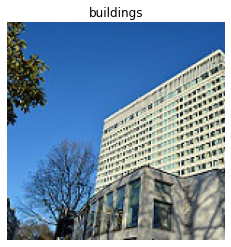

In [6]:
# img = view_random_image(target_dir='/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/',
#                   target_class='buildings')
img = view_random_image(target_dir='/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/',
                  target_class='buildings')

In [7]:
# Get the class name programmatically
import pathlib
# data_dir = pathlib.Path("/content/drive/MyDrive/Files/image_intel/seg_train/seg_train")
data_dir = pathlib.Path("/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


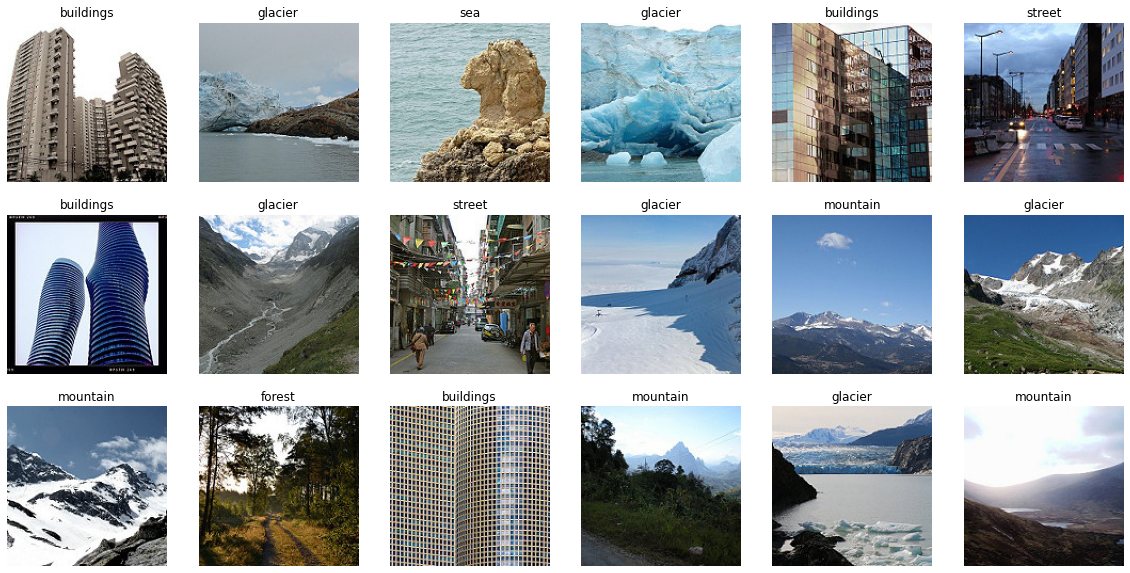

In [8]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  # img = view_random_image(target_dir='/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/',
  #                 target_class=class_name)
  img = view_random_image(target_dir='/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [9]:
# train_dir = "/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/"
# test_dir = "/content/drive/MyDrive/Files/image_intel/seg_test/seg_test/"
train_dir = "/content/drive/MyDrive/Files_sample/image_intel/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/Files_sample/image_intel/seg_test/seg_test/"

In [10]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 600 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


# Basic model Buildinig (CNN Classifier)

In [11]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [12]:
history_1 = model_1.fit(train_data,
                    #epochs=4,
                    epochs=2,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/2
19/19 [==============================] - 204s 10s/step - loss: 1.9480 - accuracy: 0.2400 - val_loss: 1.6257 - val_accuracy: 0.2250
Epoch 2/2
19/19 [==============================] - 5s 255ms/step - loss: 1.4343 - accuracy: 0.3867 - val_loss: 1.5926 - val_accuracy: 0.4083


In [13]:
model_1.evaluate(test_data)

4/4 [==============================] - 0s 88ms/step - loss: 1.5926 - accuracy: 0.4083


[1.5925991535186768, 0.40833333134651184]

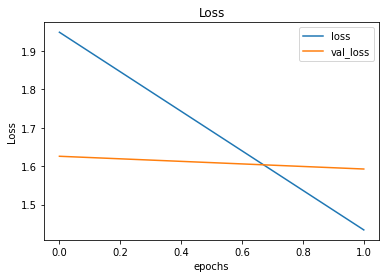

In [14]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

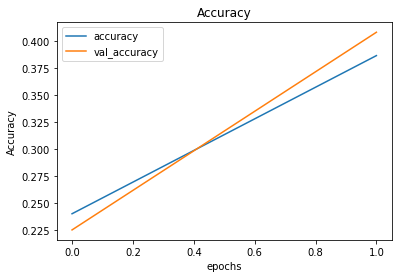

In [15]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

In [16]:
# model.save('/content/drive/MyDrive/Files/image_intel/models/', save_format='tf')
model_1.save('/content/drive/MyDrive/Files_sample/image_intel/models/', save_format='tf')

In [17]:
#!ls -alrt models
!ls -alrt /content/drive/MyDrive/Files_sample/image_intel/models

total 191
drwx------ 2 root root   4096 Feb 16 08:39 assets
drwx------ 2 root root   4096 Feb 17 11:10 variables
-rw------- 1 root root 166055 Feb 17 11:10 saved_model.pb
-rw------- 1 root root     53 Feb 17 11:10 fingerprint.pb
-rw------- 1 root root  20230 Feb 17 11:10 keras_metadata.pb


In [18]:
# model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Files/image_intel/models/models/')
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Files_sample/image_intel/models/')

In [19]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [20]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [22]:
# pred_label=model_loaded.predict(process('/content/drive/MyDrive/Files/image_intel/alto-crew-Rv3ecImL4ak-unsplash.jpg'))
pred_label=model_loaded.predict(process('/content/drive/MyDrive/Files_sample/image_intel/seg_pred/seg_pred/51.jpg'))
#print(classes[np.argmax(pred_label)])

1/1 [==============================] - 0s 29ms/step


NameError: ignored

In [23]:
pred_label

array([[0., 0., 1., 0., 0., 0.]], dtype=float32)

In [24]:
!zip -r models.zip models/

	zip warning: name not matched: models/

zip error: Nothing to do! (try: zip -r models.zip . -i models/)
